In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
import fiona
import shapely
import numpy as np
import pandas as pd
# import seaborn as sns

from glob import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [2]:
cloud_mask = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/process/image_label.tif"
shadow_raw = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/shadow_data/image_label.tif"

In [45]:
with rasterio.open(cloud_mask) as mask1:
    with rasterio.open(shadow_raw) as mask2:
        cloud = mask1.read()
        raw = mask2.read()
        meta = mask1.meta


In [46]:
shadow = ((raw==2)*(raw == cloud))*(-1)+raw

In [48]:
outmask_path = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/shadow_data/image_new.tif"
meta.update({
    "nodata": None,
    "count": 1,
    # "width": out_image.shape[1],
    # "height": out_image.shape[2]
})
with rasterio.open(outmask_path, "w", compress='lzw', **meta) as dest: # count =??
    dest.write(shadow)

In [2]:
mask_1 = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/process/image_label.tif"
mask_2 = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/shadow_data/image_new.tif"

with rasterio.open(mask_1) as m1:
    with rasterio.open(mask_2) as m2:
        mask1 = m1.read()
        mask2 = m2.read()
        meta = m1.meta

In [3]:
mask3 = ((mask1+mask2>2)+1).astype(np.uint8)
mask3

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], dtype=uint8)

In [5]:
mask_out = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/hello.tif"
with rasterio.open(mask_out, "w", compress='lzw', **meta) as dest:
    dest.write(mask3)

In [1]:
from osgeo import gdal 
dataset = gdal.Open(img_path)
values = dataset.ReadAsArray()[0:4].astype(np.float16)

NameError: name 'img_path' is not defined

In [2]:
input = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/predict/box_0267.tif"
weight_path = r"/home/geoai/eodata/cloud_detect_tensorflow/shadow_only/cp_.h5"
from shadow_only.model import build_model
unet = build_model((None,None,4), 46) #36??
unet.load_weights(weight_path)

2022-11-09 14:37:00.303997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 14:37:00.368837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 14:37:00.368965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 14:37:00.369791: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
import rasterio
import numpy as np
with rasterio.open(input) as src:
    data = np.array(src.read()).swapaxes(0,1).swapaxes(1,2).astype(np.float16)
mask = unet.predict(data[np.newaxis,...]/np.finfo(np.float16).max)

2022-11-07 15:34:20.315938: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500
2022-11-07 15:34:20.717065: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-07 15:34:20.718100: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-11-07 15:34:20.718113: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-07 15:34:20.718162: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

In [18]:
export_img_cloud_to_nodata(img_path, mask_cloud_path, out_path)


In [26]:
img_path = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/predict/add_shadow/box_0004.tif"
out_path = img_path.replace(".tif","_label.tif")

with rasterio.open(img_path) as src:
    meta = src.meta
mask = np.ones((1, src.height, src.width),dtype=np.uint8)
meta.update({
    "dtype": 'uint8',
    "count": 1
})

with rasterio.open(out_path, "w",compress='lzw', **meta) as dest:
    dest.write(mask)

In [29]:
weight_path = r"/home/skymap/public/DucAnhtmp/cloud/weight/cloud_only_model_save_sumarry.h5"
import tensorflow as tf
cnn_model=tf.keras.models.load_model(weight_path)
tf.saved_model

In [16]:
img_path = r"/home/geoai/eodata/cloud_detect_tensorflow/shadow_only/data/train/img.tif"

with rasterio.open(img_path) as src:
    meta = src.meta
    data = src.read()

In [27]:
nodata_idx = np.where(data==0)


In [23]:
data[nodata_idx] += 10000

In [3]:
weight_path = r"/home/geoai/eodata/cloud_detect_tensorflow/shadow_only/cp_stretch.h5"

from shadow_only.model import build_model
unet = build_model((None,None,4), 46) #36??
unet.load_weights(weight_path)

In [217]:
back

array([[[0.525 , 0.51  , 0.311 , 0.225 ],
        [0.52  , 0.5115, 0.3065, 0.221 ],
        [0.518 , 0.514 , 0.3055, 0.2195],
        ...,
        [0.515 , 0.4675, 0.302 , 0.232 ],
        [0.4985, 0.456 , 0.3015, 0.228 ],
        [0.4995, 0.4575, 0.2855, 0.2365]],

       [[0.519 , 0.517 , 0.3115, 0.2215],
        [0.508 , 0.521 , 0.307 , 0.2155],
        [0.512 , 0.517 , 0.3095, 0.226 ],
        ...,
        [0.513 , 0.455 , 0.2985, 0.227 ],
        [0.4945, 0.454 , 0.3055, 0.2235],
        [0.5065, 0.4635, 0.294 , 0.2305]],

       [[0.515 , 0.52  , 0.3115, 0.223 ],
        [0.522 , 0.516 , 0.3045, 0.223 ],
        [0.525 , 0.512 , 0.3005, 0.221 ],
        ...,
        [0.498 , 0.4535, 0.293 , 0.2235],
        [0.5055, 0.454 , 0.301 , 0.229 ],
        [0.522 , 0.463 , 0.2985, 0.234 ]],

       ...,

       [[0.4745, 0.429 , 0.272 , 0.208 ],
        [0.475 , 0.4225, 0.2735, 0.2025],
        [0.475 , 0.425 , 0.2715, 0.2055],
        ...,
        [0.471 , 0.4265, 0.2725, 0.207 ],
     

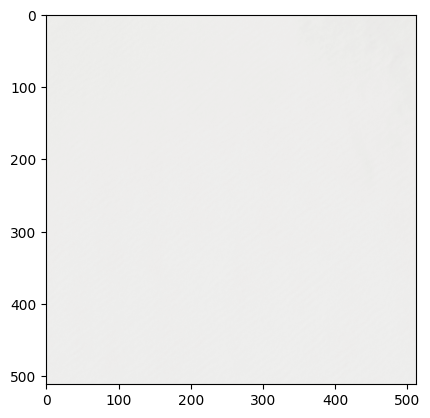

In [219]:
background = r"//home/geoai/eodata/cloud_detect_tensorflow/shadow_only/shadow_onlytrain/image/box_0005.tif"
with rasterio.open(background) as src2:
    back = src2.read().transpose(1,2,0)/5000
    idx_over = np.where(back > 1)
    back[idx_over] = 1
    plt.imshow(back)

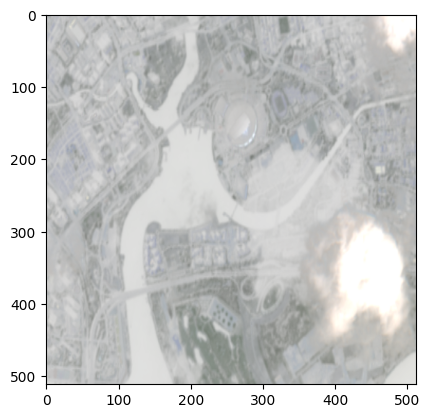

In [259]:
plt.imshow(data)

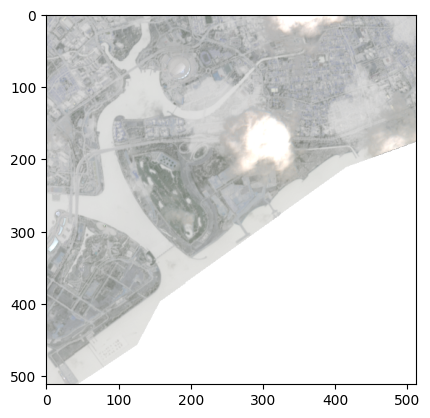

In [253]:
plt.imshow(data)

In [260]:
import cv2

input = r"/home/geoai/eodata/cloud_detect_tensorflow/shadow_only/data/train/image/box_0149.tif"
# background = r"//home/geoai/eodata/cloud_detect_tensorflow/shadow_only/shadow_onlytrain/image/box_0005.tif"
with rasterio.open(input) as src:
    
    data = src.read().transpose(1,2,0)    
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    # data = cv2.dilate(data,kernel,iterations = 100)
    data = cv2.resize(data[:250,:350,:], (512,512), interpolation=cv2.INTER_AREA)
    # with rasterio.open(background) as src2:
        # back = src2.read().transpose(1,2,0)
    # idx_nodata = np.where(data==0)
    # back[idx_nodata] = 0
    # data[idx_nodata] = back[idx_nodata]
    # for i in idx_nodata:
    #     data[i] = np.random.randint(1000,5000)
    # data[190,511,0] = 8192
    data = data/8192
    idx_over = np.where(data > 1)
    data[idx_over] = 1
out = unet.predict(data[np.newaxis,...])

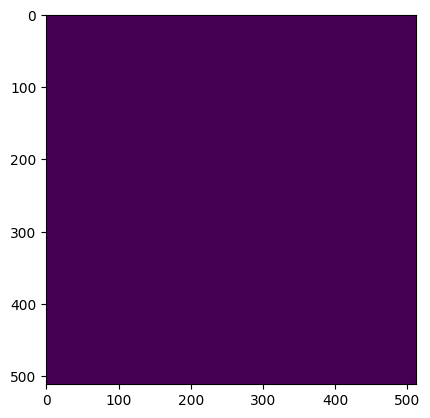

: 

In [261]:
out = out.squeeze(0)
# out[idx_nodata[0:2]] = 0

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
# dilation = cv2.dilate(out,kernel,iterations = 1)
# erosion = cv2.erode(dilation,kernel,iterations = 1)
# # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
# closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel, iterations = 2)
# opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations = 2)
# out = opening
plt.imshow(out>0.5)

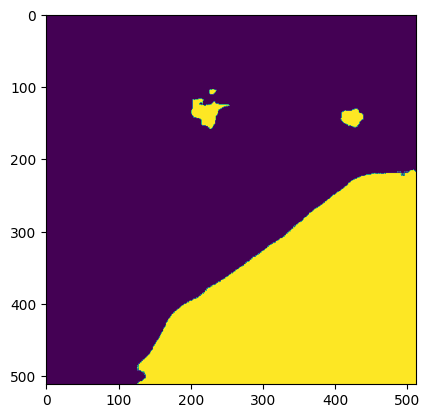

In [68]:
from cloud_noise.four_band_resize import resize